In [1]:
# importing the dependencies
import numpy as np # linear algebra
import pandas as pd # dataframe
import tensorflow as tf # Machine learning
from glob import glob # file handling
from tqdm import tqdm # progress bar
from collections import deque # for simpler implementation of memory

import matplotlib.pyplot as plt # visualisation
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Some helper functions below

Below is the code for some helper functions and is consistent across various models.

In [2]:
# function to properly return the string of price
def format_price(price):
    return ("-$" if price < 0 else "$") + "{0:.2f}".format(abs(price))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# function to get the state
def get_state(data, t, n):
    d = t - n + 1
    if d >= 0:
        block = data[d:t+1]
    else:
        # pad with t0
        block = -d*[data[0]] + data[0:t+1].tolist()
        
    # block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    
    # get results
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    
    # return numpy array
    return np.array([res])

### Load Data

The code below is to load the data and is similar across various models.

In [3]:
# load the csv file
path_folder = './data_raw/'
file_path = glob(path_folder + '*.csv')[0]
stock_name = file_path.split('.')[-2].split('/')[-1]
data = pd.read_csv(file_path)

# constants
LOG = False
episode_count = 10
window_size = 100
data = data['Close'].values # what our data is
len_data = len(data) - 1 # total information length
batch_size = 32 # minibatch size

# logs
loss_global = []
profits_global = []

Text(0.5,1,'AMZN- Amazon')

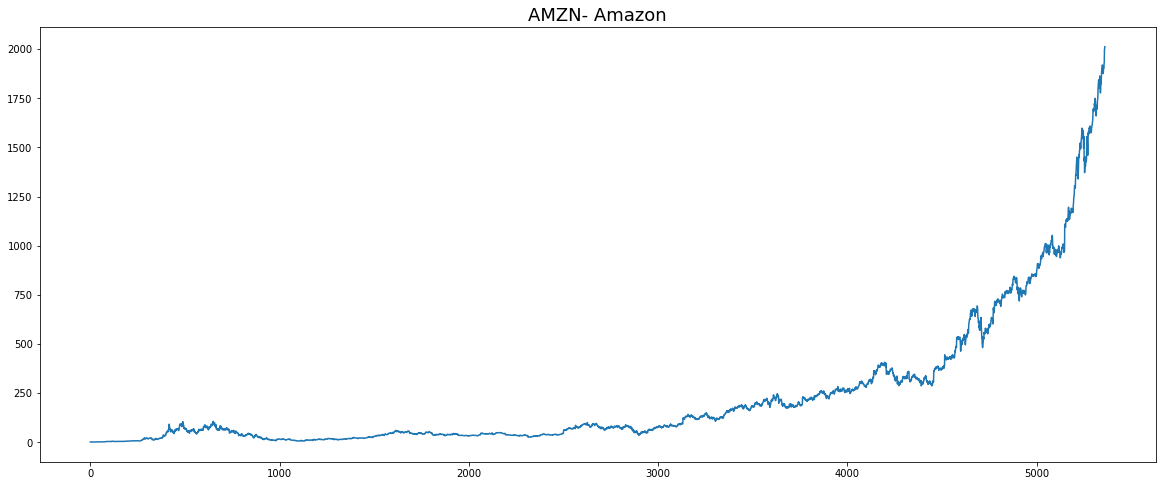

In [4]:
plt.figure(figsize = (20, 8))
plt.plot(data)
plt.title(stock_name + '- Amazon', fontsize = 18)

# Q-Learning with Replay Buffer

The Algorithm we are implementing here is the following:

![title](./blog_stuff/dqn_classic.png)

For more details read the blog [here]().

In [5]:
class AgentDQN():
    # init functions
    def __init__(self, input_dim, scope, is_eval = False, epsilon_decay_steps = 1000):
        # input_dim: state size
        # is_eval: is being evaluated
        # scope: scope of the model
        self.state_size = input_dim
        self.action_space = 3 # sell, sit, buy
        self.memory = deque(maxlen = 10000)
        self.inventory = [] # holdings that we have
        self.scope = scope # name of scope
        self.is_eval = is_eval # whether in training or deployment
        self.gamma = 0.95 # discount factor

        # greedy-epsilon policy
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay_val = (self.epsilon - self.epsilon_end)/epsilon_decay_steps

        # code to load previously trained model --> skip for now
        # self.model = load_model("models/" + model_name) if is_eval else self._model()
        self._build_model()
        self._build_loss()
        self.initialize_network()

    # inhouse functions
    def _build_model(self):
        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.target_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'target_value')

        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, 64)
        h2 = tf.contrib.layers.fully_connected(h1, 32)
        h3 = tf.contrib.layers.fully_connected(h2, 8)
        self.action_pred = tf.contrib.layers.fully_connected(h3, self.action_space)

        # print the values
        print('inputs:', self.input_placeholder)
        print('target_value:', self.target_placeholder)
        print('action_pred:', self.action_pred)

    def _build_loss(self):
        self.loss = tf.reduce_mean(tf.square(self.target_placeholder - self.action_pred))
        print('loss:', self.loss)
        self.update_step = tf.train.AdamOptimizer(0.001).minimize(self.loss)

    # user callable functions
    def initialize_network(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def save_model(self, frozen = False):
        # code to save the model as frozen inference graph (optional) or 
        # checkpoint file (default)
        if frozen:
            # convert to frozen graph here
            model_path = 'some_path'
            print('Model saved at {0}'.format(some_path))
            return
        return

    # operation functions
    def act(self, state):
        if not self.is_eval and np.random.random() <= self.epsilon:
            return np.random.randint(self.action_space)

        # else use the model to predict action
        action_dist = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
        return np.argmax(action_dist[0])

    def experience_replay(self, batch_size):
        # make the minibatch
        mini_batch = []
        mem_len = len(self.memory)
        for i in range(mem_len - batch_size + 1, mem_len):
            mini_batch.append(self.memory[i])

        # loss log
        loss_log = []

        for state, action, reward, next_state, done in mini_batch:
            target_s = reward
            if not done:
                # get predictions from model
                pred = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: next_state})

                # get the target value to be fit
                target_s = reward + self.gamma*np.amax(pred[0])

            # target value to be fit upon
            target_y = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
            target_y[0][action] = target_s

            # train the model
            feed_dict = {self.input_placeholder: state, self.target_placeholder: target_y}
            loss, _ = self.sess.run([self.loss, self.update_step], feed_dict = feed_dict)

            # add to logs
            loss_log.append(loss)

        # reduce the value of epsilon
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_val

        # return loss
        return loss_log

In [6]:
# define the agent
agent = AgentDQN(window_size, 'model_pre')

inputs: Tensor("inputs:0", shape=(?, 100), dtype=float32)
target_value: Tensor("target_value:0", shape=(?, 3), dtype=float32)
action_pred: Tensor("fully_connected_3/Relu:0", shape=(?, 3), dtype=float32)
loss: Tensor("Mean:0", shape=(), dtype=float32)


In [7]:
# run things
for e in range(episode_count):
    state = get_state(data, 0, window_size + 1)

    # init values for new episode
    total_profit = 0.0 # total profit in this epoch
    agent.inventory = [] # reset the inventory
    total_loss = [] # at each step what was the total loss
    mean_loss = [] # at each step what was the mean loss

    for t in tqdm(range(len_data)):
        action = agent.act(state)

        # next state
        next_state = get_state(data, t + 1, window_size + 1)
        reward = 0

        # now go according to actions
        if action == 2:
            # buy
            agent.inventory.append(data[t])
            if LOG:
                print('Buy:' + format_price(data[t]))


        elif action == 0 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0) # remove the first element and return the value
            profit = data[t] - bought_price # profit this iteration
            reward = max(data[t] - bought_price, 0) # reward
            total_profit += profit # add to total profit
            if LOG:
                print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))

        # condition for finish
        done = t == len_data - 1
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done and LOG:
            print("Total Profit: " + format_price(total_profit))

        # train the model
        if len(agent.memory) > batch_size:
            losses = agent.experience_replay(batch_size)
            total_loss.append(np.sum(losses))
            mean_loss.append(np.mean(losses))

    # add the mean loss to global loss
    loss_global.append(np.mean(mean_loss))
    profits_global.append(total_profit)
    
    print('[*]Episode: {0}, loss: {1}, profits: {2}'.format(e, loss_global[-1], profits_global[-1]))

  0%|          | 2/5360 [00:00<05:04, 17.61it/s]

[*]Episode: 0, loss: 0.0945732370018959, profits: 36.03064699999961


  0%|          | 2/5360 [00:00<05:22, 16.59it/s]

[*]Episode: 1, loss: 0.0045433491468429565, profits: 9.690002


  0%|          | 2/5360 [00:00<05:33, 16.04it/s]

[*]Episode: 2, loss: 0.004467894323170185, profits: -4.844200000000008


  0%|          | 2/5360 [00:00<06:35, 13.53it/s]

[*]Episode: 3, loss: 0.0053507015109062195, profits: -10.769626000000136


  0%|          | 2/5360 [00:00<04:55, 18.14it/s]

[*]Episode: 4, loss: 0.009466061368584633, profits: 7.665975000000092


  0%|          | 2/5360 [00:00<05:41, 15.70it/s]

[*]Episode: 5, loss: 0.009681923314929008, profits: 20.574966999999784


  0%|          | 2/5360 [00:00<06:11, 14.42it/s]

[*]Episode: 6, loss: 0.0054457238875329494, profits: -15.291315000000065


  0%|          | 2/5360 [00:00<04:57, 18.02it/s]

[*]Episode: 7, loss: 0.21783007681369781, profits: 39.67718099999969


  0%|          | 2/5360 [00:00<05:01, 17.80it/s]

[*]Episode: 8, loss: 0.00534070236608386, profits: -2.4111870000000657


100%|██████████| 5360/5360 [05:22<00:00, 16.62it/s]

[*]Episode: 9, loss: 0.0012952237157151103, profits: -34.3263249999998


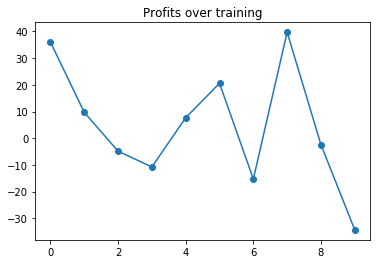

In [9]:
plt.title('Profits over training')
plt.plot(profits_global, '-o')

# Double Q-learning with target and estimator Networks

This is the algorithm we are employing here:

![title](./blog_stuff/dqn_target.png)

For more details on implementation read the blog [here](). This uses the selection and evaluation \[NN\] functions. 

In [5]:
# functions to copy parameters between two networks
def copy_parameters(q_network, target_network, sess):
    # q_network (source) to target_network (target)
    # sess: tensorflow session
    
    # source
    source_params = [t for t in tf.trainable_variables() if t.name.startswith(q_network.scope)]
    source_params = sorted(source_params, key = lambda v: v.name)
    
    # target
    target_params = [t for t in tf.trainable_variables() if t.name.startswith(target_network.scope)]
    target_params = sorted(target_params, key = lambda v: v.name)
    
    # do assign operations in loop
    for s_v, t_v in zip(source_params, target_params):
        op = t_v.assign(s_v)
        sess.run(op)

In [6]:
class DoubleDQN():
    # initialization function
    def __init__(self, input_dim, scope, is_eval = False):
        # input_dim: state size
        # is_eval: is being evaluated
        # scope: scope of the model
        self.state_size = input_dim
        self.action_space = 3 # sell, sit, buy
        self.scope = scope # name of scope

        # code to load previously trained model --> skip for now
        # self.model = load_model("models/" + model_name) if is_eval else self._model()
        self._build_model()
        self._build_loss()

    # inhouse functions
    def _build_model(self):
        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.q_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'q_value')

        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, 64)
        h2 = tf.contrib.layers.fully_connected(h1, 32)
        h3 = tf.contrib.layers.fully_connected(h2, 8)
        self.action_pred = tf.contrib.layers.fully_connected(h3, self.action_space, activation_fn = tf.nn.softmax)

    def _build_loss(self):
        self.loss = tf.reduce_mean(tf.square(self.q_placeholder - self.action_pred))
        self.update_step = tf.train.AdamOptimizer(0.001).minimize(self.loss)
        
    # user callable functions
    def save_model(self, frozen = False):
        # code to save the model as frozen inference graph (optional) or 
        # checkpoint file (default)
        if frozen:
            # convert to frozen graph here
            model_path = 'some_path'
            print('Model saved at {0}'.format(some_path))
            return
        return
    
    # no need for operation functions since everything is called from outside

In [7]:
def train_dqn(q_network,
              target_network,
              sess,
              data,
              max_mem_size = 1000,
              num_episodes = 50,
              train_target_every = 2,
              gamma = 0.99,
              epsilon_start = 0.99,
              epsilon_end = 0.001,
              epsilon_decay = 0.995):
    # function variables
    train_global_step = 0 # global step needed in parameter update
    train_loss = [] # training loss in each episode
    train_profits = [] # for profits in each episode
    
    # memory_buffer
    memory_buffer = []
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # init stuff
    epsilon = epsilon_start
    
    # iterate over each episode
    for ep in range(num_episodes):
        # for each training episode
        state = get_state(data, 0, window_size + 1)
        
        # init values for new episode
        total_profit = 0.0 # total profit in this episode
        # q_network.inventory = [] # holdings by q_network
        inventory = [] # inventory for this episode
        ep_loss = [] # total loss in this episode
        
        for t in tqdm(range(len_data)):
            # take action according to epsilon greedy policy
            if np.random.random() > epsilon:
                action = np.random.randint(q_network.action_space)
            else:
                feed_dict = {q_network.input_placeholder: state}
                action = sess.run(q_network.action_pred, feed_dict = feed_dict)
                action = np.argmax(action[0])
            
            # next state
            next_state = get_state(data, t + 1, window_size + 1)
            reward = 0
            
            # now go according to the actions
            if action == 2:
                # buy
                inventory.append(data[t])
                if LOG:
                    print('Buy:' + format_price(data[t]))
                    
            elif action == 0 and len(inventory) > 0:
                bought_price = inventory.pop(0) # remove the first element and return the value
                profit = data[t] - bought_price # profit this transaction
                reward = max(data[t] - bought_price, 0) # reward
                total_profit += profit # add to total profit
                if LOG:
                    print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))
                    
            # condition for done
            done = t == len_data - 1
            
            # add to memory and make sure it's of fixed size
            memory_buffer.append((state, action, reward, next_state, done))
            if len(memory_buffer) > max_mem_size:
                memory_buffer.pop(0)
            
            # update state
            state = next_state
            
            # train the model
            if len(memory_buffer) > batch_size:
                
                # sample minibatches here
                mini_batch = memory_buffer[-batch_size:]
                    
                # calculate q_value and target_values
                for state_t, action_t, reward_t, next_state_t, done_t in mini_batch:
                    # condition for calculating y_j
                    if done_t:
                        target_pred = reward
                    
                    else:
                        feed_dict = {target_network.input_placeholder: next_state_t}
                        target_pred = sess.run(target_network.action_pred, feed_dict = feed_dict)
                        target_value = reward_t + gamma*np.amax(target_pred[0])
                    
                    # q_value
                    feed_dict = {q_network.input_placeholder: state_t}
                    q_values = sess.run(q_network.action_pred, feed_dict = feed_dict)
                    q_values[0][action_t] = target_value
                    
                    # drop epsilon value after every action taken
                    if epsilon > epsilon_end:
                        epsilon *= epsilon_decay
                    
                    # update the q_network parameters
                    feed_dict = {q_network.input_placeholder: state_t,
                                 q_network.q_placeholder: q_values}
                    loss, _ = sess.run([q_network.loss, q_network.update_step], feed_dict = feed_dict)
                    
                    # update the lists
                    ep_loss.append(loss)
                    
                    # update target network
                    train_global_step += 1
                    if ep % train_target_every == 0:
                        copy_parameters(q_network, target_network, sess)
                        
        # update the outer values
        train_loss.append(ep_loss)
        train_profits.append(total_profit)
        
        # print val
        print('[*]Episode: {0}, loss: {1}, profits: {2}, epsilon: {3}'\
              .format(ep + 1, np.mean(train_loss[-1]), train_profits[-1], epsilon))
    
    # return the values
    return train_loss, train_profits

In [8]:
# run the model
q_network = DoubleDQN(window_size, 'q_network')
target_network = DoubleDQN( window_size, 'target_network')
sess = tf.Session()
loss, profits = train_dqn(q_network, target_network, sess, data)

  0%|          | 2/5360 [00:00<08:37, 10.36it/s]

[*]Episode: 1, loss: 2090.693359375, profits: 92243.883383, epsilon: 0.0009954452565571535


 46%|████▌     | 2454/5360 [02:38<03:08, 15.45it/s]

KeyboardInterrupt: 

# Dueling DQN (DDQN)

Below is the architecture and code for dueling DQN. In this architecture, the network calculates two sepearate values Advantage `A(s,a)` and value `v(s)` for any given state, the q-value is then given by `Q(s,a) = A(s,a) + v(s)`

![title](./blog_stuff/dueling_dqn.png)

In [5]:
class DDQN():
    def __init__(self, input_dim, scope):
        self.state_size = input_dim
        self.scope = scope
        self.action_space = 3
        
        # placeholders
        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.q_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'q_value')
        
        # build model
        self._build_model()
        self._build_loss()
        
    def _build_model(self):
        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, 64)
        common_h2 = tf.contrib.layers.fully_connected(h1, 32)
        
        # value network layers
        val_h3 = tf.contrib.layers.fully_connected(common_h2, 8)
        self.value = tf.contrib.layers.fully_connected(val_h3, 1)
        
        # advantage network layers
        adv_h3 = tf.contrib.layers.fully_connected(common_h2, 16)
        self.advantage = tf.contrib.layers.fully_connected(adv_h3, self.action_space)
        
        # get the final q value
        # tensorflow automatically perform the calculation of type [1,1] + [1,3] = [1,3]
        # Q(s,a) = V(s) + (A(s,a) - 1/|A|(sum(A(s,a))))
        self.action_pred = self.value + (self.advantage - tf.reduce_mean(self.advantage, axis = 1, keepdims = True)) 
        
    def _build_loss(self):
        self.loss = tf.reduce_mean(tf.square(self.action_pred - self.q_placeholder))
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)


In [6]:
def train_ddqn(network,
               sess,
               data,
               max_mem_size = 1000,
               num_episodes = 50,
               gamma = 0.99,
               epsilon_start = 0.99,
               epsilon_end = 0.001,
               epsilon_decay = 0.995):
    # function variables
    train_global_step = 0 # global step needed in parameter update
    train_loss = [] # training loss in each episode
    train_profits = [] # for profits in each episode
    
    # memory_buffer
    memory_buffer = []
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # init stuff
    epsilon = epsilon_start
    
    # iterate over each episode
    for ep in range(num_episodes):
        # for each training episode
        state = get_state(data, 0, window_size + 1)
        
        # init values for new episode
        total_profit = 0.0 # total profit in this episode
        # q_network.inventory = [] # holdings by q_network
        inventory = [] # inventory for this episode
        ep_loss = [] # total loss in this episode
        
        for t in tqdm(range(len_data)):
            # take action according to epsilon greedy policy
            if np.random.random() > epsilon:
                action = np.random.randint(q_network.action_space)
            else:
                feed_dict = {q_network.input_placeholder: state}
                action = sess.run(q_network.action_pred, feed_dict = feed_dict)
                action = np.argmax(action[0])
            
            # next state
            next_state = get_state(data, t + 1, window_size + 1)
            reward = 0
            
            # now go according to the actions
            if action == 2:
                # buy
                inventory.append(data[t])
                if LOG:
                    print('Buy:' + format_price(data[t]))
                    
            elif action == 0 and len(inventory) > 0:
                bought_price = inventory.pop(0) # remove the first element and return the value
                profit = data[t] - bought_price # profit this transaction
                reward = max(data[t] - bought_price, 0) # reward
                total_profit += profit # add to total profit
                if LOG:
                    print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))
                    
            # condition for done
            done = t == len_data - 1
            
            # add to memory and make sure it's of fixed size
            memory_buffer.append((state, action, reward, next_state, done))
            if len(memory_buffer) > max_mem_size:
                memory_buffer.pop(0)
            
            # update state
            state = next_state
            
            # train the model
            if len(memory_buffer) > batch_size:
                
                # sample minibatches here
                mini_batch = memory_buffer[-batch_size:]
                    
                # calculate q_value and target_values
                for state_t, action_t, reward_t, next_state_t, done_t in mini_batch:
                    # condition for calculating y_j
                    if done_t:
                        target_pred = reward
                    
                    else:
                        feed_dict = {network.input_placeholder: next_state_t}
                        network_pred = sess.run(network.action_pred, feed_dict = feed_dict)
                        target_value = reward_t + gamma*np.amax(network_pred[0])
                    
                    # q_value
                    feed_dict = {network.input_placeholder: state_t}
                    q_values = sess.run(network.action_pred, feed_dict = feed_dict)
                    q_values[0][action_t] = target_value
                    
                    # drop epsilon value after every action taken
                    if epsilon > epsilon_end:
                        epsilon *= epsilon_decay
                    
                    # update the q_network parameters
                    feed_dict = {network.input_placeholder: state_t,
                                 network.q_placeholder: q_values}
                    loss, _ = sess.run([q_network.loss, q_network.train_step], feed_dict = feed_dict)
                    
                    # update the lists
                    ep_loss.append(loss)
                    
        # update the outer values
        train_loss.append(ep_loss)
        train_profits.append(total_profit)
        
        # print val
        print('[*]Episode: {0}, loss: {1}, profits: {2}, epsilon: {3}'\
              .format(ep + 1, np.mean(train_loss[-1]), train_profits[-1], epsilon))
    
    # return the values
    return train_loss, train_profits

In [7]:
# run the model
q_network = DDQN(window_size, 'q_network')
sess = tf.Session()
loss, profits = train_ddqn(q_network, sess, data)

  0%|          | 2/5360 [00:00<05:33, 16.05it/s]

[*]Episode: 1, loss: 1380.010009765625, profits: 78631.64690499997, epsilon: 0.0009954452565571535


  0%|          | 2/5360 [00:00<05:45, 15.50it/s]

[*]Episode: 2, loss: 486.006103515625, profits: 31529.893303999997, epsilon: 0.0009954452565571535


  0%|          | 2/5360 [00:00<05:41, 15.67it/s]

[*]Episode: 3, loss: 1633.228759765625, profits: 82862.40621299998, epsilon: 0.0009954452565571535


  0%|          | 2/5360 [00:00<05:24, 16.49it/s]

[*]Episode: 4, loss: 1822.4794921875, profits: 89303.44369399996, epsilon: 0.0009954452565571535


 63%|██████▎   | 3383/5360 [09:32<05:34,  5.91it/s]

KeyboardInterrupt: 

 63%|██████▎   | 3383/5360 [09:42<05:40,  5.80it/s]